In [2]:
# Import imports

import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import geopandas
import plotly.express as px
from shapely.geometry import Point, Polygon

In [180]:
# import the data sources we will be playing with
grow = pd.read_csv('https://data.wprdc.org/dataset/0d8c9708-3f01-48c4-adff-04d29825c9a2/resource/dbdfcb3e-8fa5-4468-9b05-f69562798f7a/download/growpghgardens201712.csv')
trash = pd.read_csv('https://data.wprdc.org/datastore/dump/75b83ac9-8069-4cf1-bcc3-b9e6b04487d9')
grow = grow.drop(['url', 'country', 'state', 'grower_id'], axis = 1) # clean up data by dropping some columns
grow = grow[grow.city == 'Pittsburgh'] # limit to pittsburgh city




In [273]:
# get the neighborhood map
neighborhoods = geopandas.read_file("Neighborhoods/Neighborhoods_.shp") # read in the shapefile
crs = {'init': 'EPSG:4326'} #this is a coordinate reference system, but not really sure how it works
# need to add geometry so we can drop points on the map, and potentially add a column later
geometry = [Point(xy) for xy in zip(grow["longitude"], grow['latitude'])]

#geo_df = geopandas.GeoDataFrame(grow, crs = crs, geometry=geometry)
geo_df = geopandas.GeoDataFrame(grow, geometry=geometry) # i don't think we need crs anymore, should be built in




In [272]:
# attempt to merge the neighborhood data into the trash can data and map on plotly


# convert plain df to geopandas df

geo_df_geopanda = geopandas.GeoDataFrame(geo_df, geometry=geopandas.points_from_xy(geo_df.longitude, geo_df.latitude))
geo_df_geopanda = geo_df_geopanda.set_crs("EPSG:4326")   # don't think I need this anymore
geo_df = geo_df.set_crs("EPSG:4326")

point_in_neigh = geopandas.sjoin(geo_df, neighborhoods, how='left', op='within')
                
# going to try and make map of this data now
# plotly version of the data, so can zoom and get neighborhood maps, etc
px.set_mapbox_access_token('pk.eyJ1Ijoia2V5b25jYWwiLCJhIjoiY2tuYWM4b25rMWc5djJvbGdyYmFuN3c4MiJ9.CxmqbsOMXQHFuVwsUEFoTg')
fig = px.scatter_mapbox(point_in_neigh, lat="latitude", lon="longitude", zoom=11, hover_name='hood')                  
fig.show()





In [82]:
# time to work on trash can data. 
# gonna try convert it to geo pandas, and maybe helps get the neighborhood name
trash_df = trash # copy just in case 

trash_geo = geopandas.GeoDataFrame(trash_df, geometry=geopandas.points_from_xy(trash_df.x, trash_df.y))
trash_geo.set_crs("EPSG:4326")

px.set_mapbox_access_token('pk.eyJ1Ijoia2V5b25jYWwiLCJhIjoiY2tuYWM4b25rMWc5djJvbGdyYmFuN3c4MiJ9.CxmqbsOMXQHFuVwsUEFoTg')
fig = px.scatter_mapbox(trash_geo, lat="y", lon="x", zoom=11, hover_name="neighborhood")                  
fig.show()

# this cell works to get the trash cans on the map, and show the neighborhood on hover

In [259]:
# want to merge the two data sets so can do metric of trash_grow / 100 people
grow_neigh = point_in_neigh
trash_df = trash_geo

trash_df=trash_df.rename(columns={'neighborhood':'hood'})   # rename columns so they match for the aggregate

# want to know how many trash and food are in each neighborhood. So going to just do a count of neighborhoods in eac
grow_neigh_group= grow_neigh.dissolve(by='hood', aggfunc='count')
trash_df_group = trash_df.dissolve(by='hood', aggfunc='count')

# now need to merge the data
merged_df = trash_df_group.merge(grow_neigh_group, on='hood', how='left')   # trash has more entries so merge on left
merged_df = merged_df[['container_id', 'page_numbe']]   # since just a count, we only need these two columns (maybe add geometry later)
merged_df = merged_df.rename(columns={'container_id':'smart_trash', 'page_numbe': 'food_garden'})  # rename columns to make clear
merged_df['food_garden'] = merged_df['food_garden'].fillna(0)   # get rid of the NaN by replacing with 0


merged_df



,smart_trash,food_garden
hood,,
Allegheny Center,8,0.0
Allegheny West,15,0.0
Allentown,12,0.0
Arlington,2,0.0
Banksville,2,0.0
...,...,...
Upper Lawrenceville,16,0.0
West End,9,1.0
West Oakland,9,3.0


In [260]:
# now that we just have the breakdown of smart_trash and food_garden by neighborhood lets get population
#pop_df = pd.read_csv('https://data.wprdc.org/dataset/3cb2b9c2-66e2-4ffa-b0a1-35fb2c6f7230/resource/eb1f8714-e0eb-4614-acfe-dfe0ebab942f/download/school-enrollment-by-detailed-level-of-school-for-the-population-3-years-and-over.csv')
pop_df = pd.read_csv('https://data.wprdc.org/dataset/40188e1c-6d2e-4f20-9391-607bd3054949/resource/8ac5c768-09ba-43a8-829f-ce4a417d20fb/download/population-density.csv')
pop_df = pop_df[['Neighborhood', 'Land Area (acres)', 'Pop. 2010']]   # only want the population
pop_df = pop_df.rename(columns = {'Neighborhood':'hood', 'Land Area (acres)':'area', 'Pop. 2010':'pop'})  #rename the columns
merged_final = merged_df.merge(pop_df, how='left', on='hood')
merged_final.replace(',','', regex=True, inplace=True)
merged_final['area'] = merged_final['area'].astype(float)
merged_final['pop'] = merged_final['pop'].astype(float)
merged_final['percent_pop'] = merged_final['pop'] / merged_final['pop'].sum()
merged_final

,hood,smart_trash,food_garden,area,pop,percent_pop
0,Allegheny Center,8,0.0,134.4,933.0,0.003156
1,Allegheny West,15,0.0,90.2,462.0,0.001563
2,Allentown,12,0.0,188.8,2500.0,0.008457
3,Arlington,2,0.0,300.8,1869.0,0.006322
4,Banksville,2,0.0,620.2,4144.0,0.014018
...,...,...,...,...,...,...
74,Upper Lawrenceville,16,0.0,259.2,2669.0,0.009028
75,West End,9,1.0,128.0,254.0,0.000859
76,West Oakland,9,3.0,137.6,2604.0,0.008808
77,Westwood,5,0.0,442.9,3066.0,0.010371


In [256]:
# now we can add the column for the metric
merged_final.describe()    # to help guide us for weighting garden more

,smart_trash,food_garden,area,pop,percent_pop
count,79.000000,79.000000,79.000000,79.000000,79.000000
mean,16.025316,1.303797,396.905063,3742.101266,0.012658
std,18.124905,0.773842,309.291995,3290.050384,0.011129
min,1.000000,1.000000,64.000000,11.000000,0.000037
25%,4.000000,1.000000,181.400000,1365.000000,0.004617
50%,9.000000,1.000000,284.800000,2714.000000,0.009181
75%,19.000000,1.000000,532.150000,4742.000000,0.016041
max,78.000000,4.000000,1709.400000,15110.000000,0.051112


,hood,smart_trash,food_garden,area,pop,percent_pop,clean_score
60,South Shore,1,0.0,135.7,19.0,0.000064,0.000047
18,Chateau,4,0.0,245.1,11.0,0.000037,0.000061
67,St. Clair,1,0.0,198.4,209.0,0.000707,0.000356
23,East Carnegie,1,0.0,276.5,570.0,0.001928,0.000697
70,Swisshelm Park,1,0.0,307.2,1361.0,0.004604,0.001499
...,...,...,...,...,...,...,...
9,Bluff,32,1.0,209.3,6600.0,0.022326,0.394670
8,Bloomfield,60,2.0,449.3,8442.0,0.028556,0.444902
25,East Liberty,72,4.0,371.8,5869.0,0.019853,0.491247
17,Central Oakland,44,0.0,179.8,6086.0,0.020587,0.503793


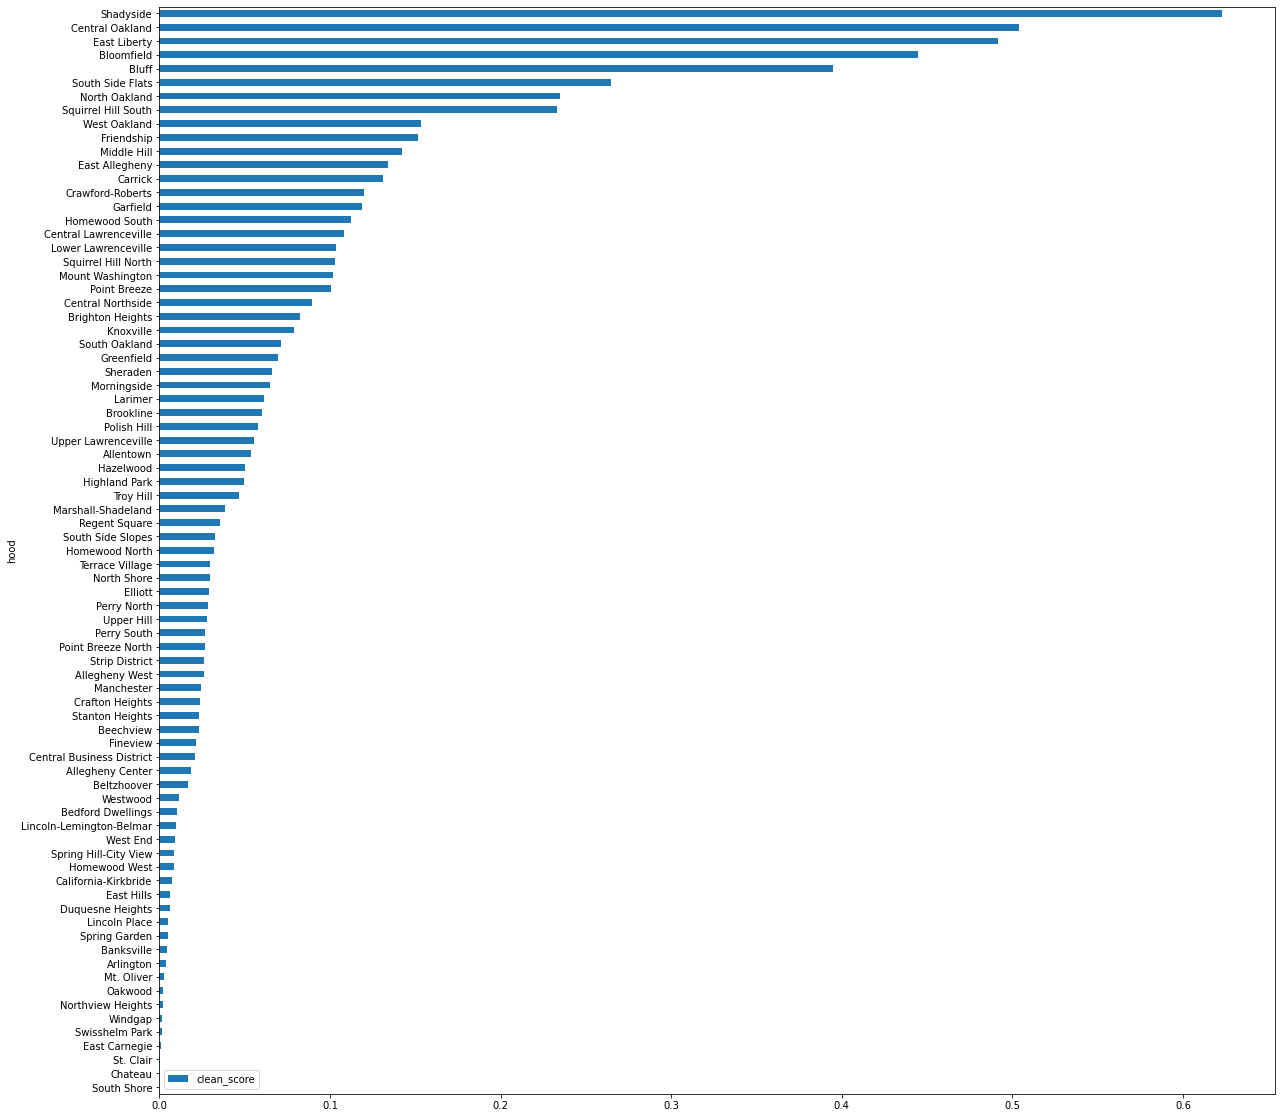

In [271]:
# we will make every food garden worth 5 points, and every trash can worth 1 point
# then we will figure out how many points per area size and weight by populations percent.
# Hopefully giving us our best areas in pitt as judged by level of community and cleanliness
merged_final['clean_score'] = ((merged_final['smart_trash'] + (merged_final['food_garden'] * 5)) / (merged_final['area']/100)) * merged_final['percent_pop']

# lets see how the data looks on a bar graph


merged_final_sort = merged_final.sort_values(by=['clean_score'], ascending=True)

graph = merged_final_sort.plot.barh(x='hood', y='clean_score', figsize=(20, 20))
merged_final_sort